In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

rdir = '../results_blackbox/'
pstreedir = '../results_blackbox_pstree/'
figdir = '../paper/'
datadir = '../datasets/pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')

symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman',

    'Brush',
    'Brush wo split',
    'Brush (D-UCB1)',
    'Brush (C-D-UCB1)',
    'Brush (D-TS)',
    'Brush (C-D-TS)',
    'Brush wo split (D-UCB1)',
    
    # Fixed labels
    'Brush w/ split (no MAB)',

    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # short fixed labels
    'Brush_0',
    'Brush+S',
    'Brush+M',
    'Brush+SM',
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',

    'Brush',
    'Brush wo split',
    'Brush (D-UCB1)',
    'Brush (C-D-UCB1)',
    'Brush (D-TS)',
    'Brush (C-D-TS)',
    'Brush wo split (D-UCB1)',
    
    # Fixed labels
    'Brush w/ split (no MAB)',

    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # short fixed labels
    'Brush_0',
    'Brush+S',
    'Brush+M',
    'Brush+SM',
]

##########
# load results
##########
df_results = pd.read_feather('../results/black-box_results_srbench.feather')

# df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_500_dom.feather'), df_results], axis=0)
# df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_500.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_250.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_pstree.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_dso.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_tpsr.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_e2et.feather'), df_results], axis=0)

# df_results.reset_index()

df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush$', r'Brush w/ split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush wo split$', r'Brush w/o split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush wo', r'Brush w/o'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush (', r'Brush w/ split ('))

# Short labels
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (no MAB)',r'$Brush_0$'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (no MAB)','Brush+S'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (D-UCB1)','Brush+M'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (D-UCB1)','Brush+SM'))

# Visualize different mabs.
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush+SM','Brush+M (D-UCB1)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (C-D-UCB1)','Brush+M (C-D-UCB1)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (D-TS)','Brush+M (D-TS)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (C-D-TS)','Brush+M (C-D-TS)'))

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]


df_results = df_results[ ~df_results["dataset"].isin([
                                                        "nikuradse_2",
                                                        "nikuradse_1"
]) ]

df_results = df_results[ ~df_results["algorithm"].isin([
    # Comment out which you want to use in the plots
    
    # 'Brush_0',
    'Brush+S',
    # 'Brush+M',
    'Brush+SM',

    'Brush w/ split (no MAB)',
    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # "uDSR",
    # "E2E",
    # "TPSR+E2E",
    # "NeSymRes 10M",
    # "NeSymRes 100M",
]) ]

print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

figdir: ../paper/
mean trial count:
algorithm
AIFeynman        7.816667
TPSR+E2E         9.058333
E2E              9.866667
MRGP             9.908333
$Brush_0$        9.958333
uDSR             9.958333
Brush+M          9.975000
FEAT             9.991667
XGB             10.000000
AFP             10.000000
SBP-GP          10.000000
RandomForest    10.000000
PS-Tree         10.000000
Operon          10.000000
AFP_FE          10.000000
MLP             10.000000
Linear          10.000000
LGBM            10.000000
KernelRidge     10.000000
gplearn         10.000000
GP-GOMEA        10.000000
FFX             10.000000
EPLEX           10.000000
AdaBoost        10.000000
DSR             10.000000
BSR             10.000000
ITEA            10.000000
Name: dataset, dtype: float64


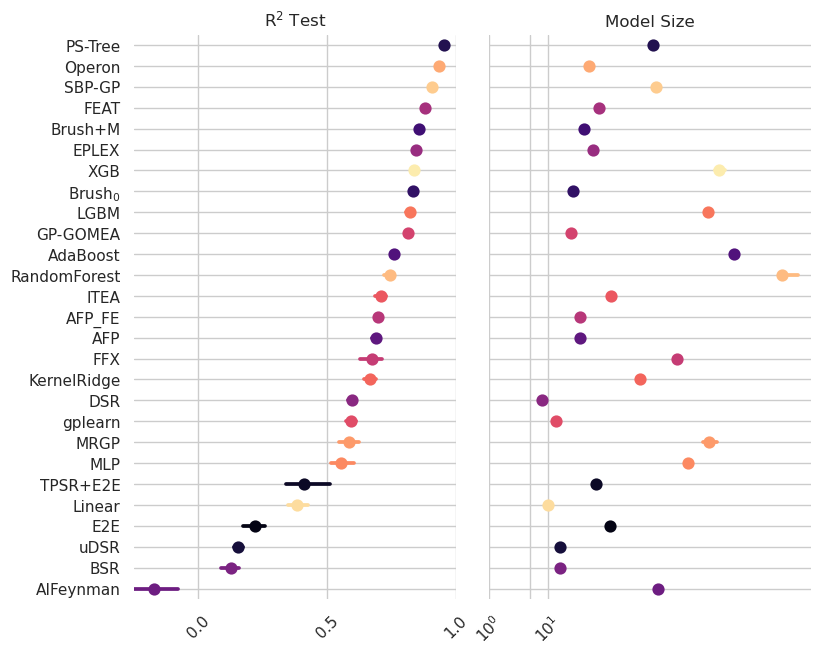

In [2]:
# Make the PairGrid
sns.set_style("whitegrid")
# sns.set(palette='magma')

# different options
x_vars=[
        'r2_test',
        'model_size',
        #'training time (s)',
]
order = df_results.groupby('algorithm')[x_vars[0]].median().sort_values(ascending=False).index
g = sns.PairGrid(df_results, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 hue='algorithm',
                  palette="magma",
                 height=6.5, 
                 aspect=0.6,
                )

# Draw a dot plot 

g.map(sns.pointplot, 
      #markersize=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="magma",
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95,
      #annot_kws={'rotation': 45}
     )

# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    if title == "Model Size":
        ax.set_xticks([1, 5, 10])
    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', labelrotation = 45)

sns.despine(left=True, bottom=True)
sns.set(font_scale=2)


#save(name='_'.join(['pairgrid-pointplot']+x_vars))
# plt.savefig("figs/main_results.pdf", bbox_inches='tight')

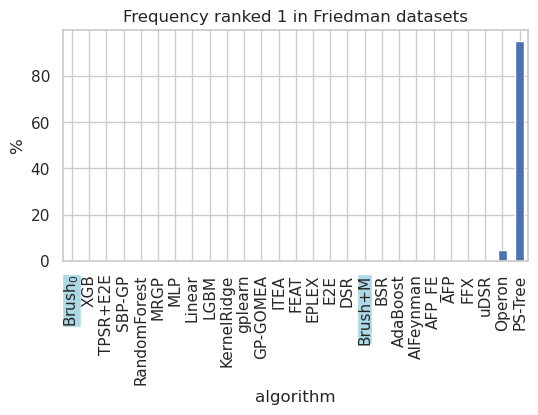

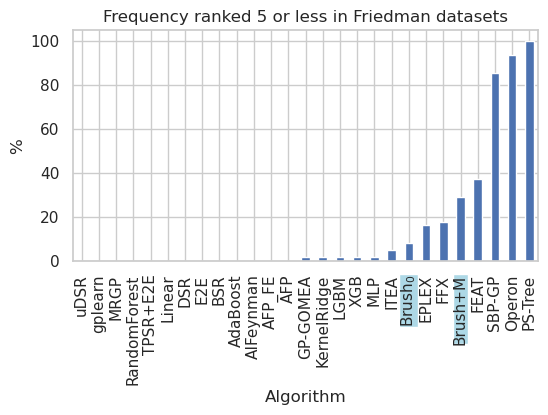

In [3]:
df_results['*algorithm*'] = df_results['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
sns.set(font_scale=1.0, style='whitegrid')

df_pivot = pd.pivot_table(df_results[df_results.dataset.str.contains("_fri_")], index='algorithm', columns=['dataset'], values='r2_test').apply(lambda x: np.round(x,4))
ranks = df_pivot.rank(ascending=False, method='min')
plt.rcParams.update({'font.size': 30, 'pdf.fonttype' : 42, 'ps.fonttype' : 42})
n = len(ranks.columns)

fig = plt.figure(figsize=(6,3))
ranks.apply(lambda xs: np.array([100.0/n if x < 2 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(ylabel='%', title='Frequency ranked 1 in Friedman datasets')

for ticklbl in fig.axes[0].xaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

plt.savefig(figdir+'/'+'hist1fri.svg', bbox_inches="tight")
plt.savefig(figdir+'/'+'hist1fri.pdf', bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6,3))
ranks.apply(lambda xs: np.array([100.0/n if x < 5 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(
    ylabel='%',
    xlabel='Algorithm',
    title='Frequency ranked 5 or less in Friedman datasets')

for ticklbl in fig.axes[0].xaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

plt.savefig(figdir+'/'+'hist5fri.svg', bbox_inches="tight")
plt.savefig(figdir+'/'+'hist5fri.pdf', bbox_inches="tight")
plt.show()

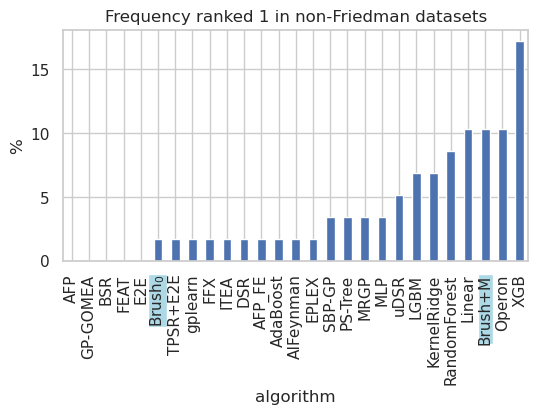

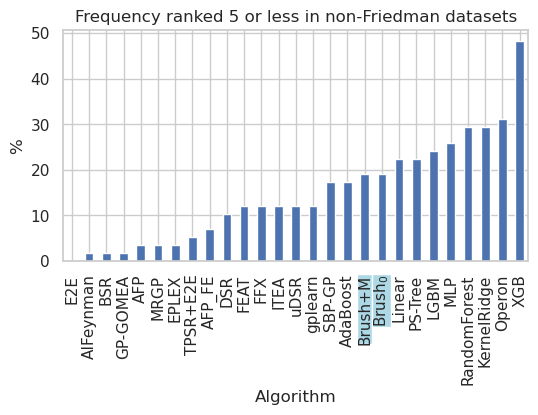

In [4]:
df_results['*algorithm*'] = df_results['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

df_pivot = pd.pivot_table(df_results[~df_results.dataset.str.contains("_fri_")], index='algorithm', columns=['dataset'], values='r2_test').apply(lambda x: np.round(x,4))
ranks = df_pivot.rank(ascending=False, method='min')
plt.rcParams.update({'font.size': 30, 'pdf.fonttype' : 42, 'ps.fonttype' : 42})
n = len(ranks.columns)

fig = plt.figure(figsize=(6,3))
ranks.apply(lambda xs: np.array([100.0/n if x < 2 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(ylabel='%', title='Frequency ranked 1 in non-Friedman datasets')

for ticklbl in fig.axes[0].xaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

plt.savefig(figdir+'/'+'hist1nonfri.svg', bbox_inches="tight")
plt.savefig(figdir+'/'+'hist1nonfri.pdf', bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(6,3))
ranks.apply(lambda xs: np.array([100.0/n if x < 5 else 0 for x in xs]).sum(), axis=1).sort_values().plot.bar(
    ylabel='%',
    xlabel='Algorithm',
    title='Frequency ranked 5 or less in non-Friedman datasets')

for ticklbl in fig.axes[0].xaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

plt.savefig(figdir+'/'+'hist5nonfri.svg', bbox_inches="tight")
plt.savefig(figdir+'/'+'hist5nonfri.pdf', bbox_inches="tight")
plt.show()

/tmp/ipykernel_3107623/2472457485.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)


58


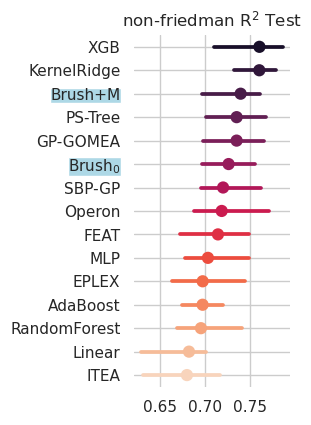

In [5]:
# Make the PairGrid
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 24, 'pdf.fonttype' : 42, 'ps.fonttype' : 42})

# different options
x_vars=[
        'r2_test',
        #'model_size',
        #'training time (s)',
]

df_p = df_results[~df_results.dataset.str.contains("_fri_")]#.sort_values(by='r2_test',ascending=False).head(10)

df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

print(len(df_p['dataset'].unique()))
order = df_p.groupby('algorithm')[x_vars[0]].median().sort_values(ascending=False).index[:15]
g = sns.PairGrid(df_p, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=4.5, 
                 aspect=0.6,
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="rocket",
      #linewidth=1,
     #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','non-friedman $R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
sns.set(font_scale=1)

for ticklbl in g.axes.flat[0].yaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

#save(name='_'.join(['pairgrid-pointplot']+x_vars))
plt.savefig(figdir+'/'+"nonfri_results.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_3107623/3471398832.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)


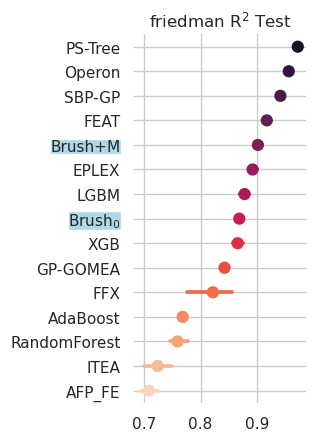

In [6]:
# Make the PairGrid
sns.set_style("whitegrid")

# different options
x_vars=[
        'r2_test',
        #'model_size',
        #'training time (s)',
]

df_p = df_results[df_results.dataset.str.contains("_fri_")]

df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

order = df_p.groupby('algorithm')[x_vars[0]].median().sort_values(ascending=False).index[:15]
g = sns.PairGrid(df_p, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=4.5, 
                 aspect=0.6,
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="rocket",
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','friedman $R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
sns.set(font_scale=1)

for ticklbl in g.axes.flat[0].yaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

#save(name='_'.join(['pairgrid-pointplot']+x_vars))
plt.savefig(figdir+'/'+"fri_results.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_3107623/1178938562.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)


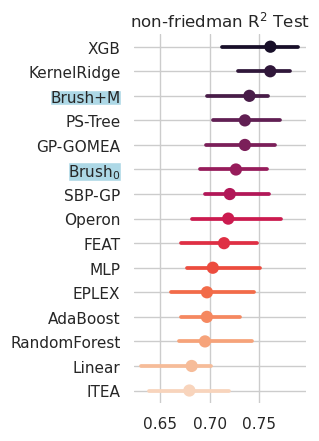

In [7]:
# Make the PairGrid
sns.set_style("whitegrid")

smallests = ["192_vineyard", "228_elusage", "485_analcatdata_vehicle", "1096_FacultySalaries", 
             "523_analcatdata_neavote", "663_rabe_266", "687_sleuth_ex1605", "659_sleuth_ex1714",
             "678_visualizing_environmental", "611_fri_c3_100_5", "594_fri_c2_100_5", "624_fri_c0_100_5",
             "656_fri_c1_100_5", "210_cloud", "706_sleuth_case1202", "1089_USCrime", "712_chscase_geyser1",
             "542_pollution", "527_analcatdata_election2000"]


# different options
x_vars=[
        'r2_test',
        #'log_mse_test',
        #'model_size',
        #'training time (s)',
]

df_p = df_results[~df_results.dataset.str.contains("_fri_")]

df_p['*algorithm*'] = df_p['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

order = df_p.groupby('algorithm')[x_vars[0]].median().sort_values(ascending=False).index[:15]
g = sns.PairGrid(df_p, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=4.5, 
                 aspect=0.6,
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="rocket",
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','non-friedman $R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
sns.set(font_scale=1)

for ticklbl in g.axes.flat[0].yaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
        # ticklbl.set_c('blue')

#save(name='_'.join(['pairgrid-pointplot']+x_vars))
plt.savefig(figdir+'/'+"penalty_nonfri_results.pdf", bbox_inches='tight')
plt.show()

In [8]:
import Orange
print(Orange.__version__)

# critical difference for Nemenyi with alpha=0.05
def cd_plot(df, pname):
    if df.empty:
        return
    df_pivot = pd.pivot_table(df, index='algorithm', columns=['dataset'], values='r2_test')
    n = len(df_pivot.columns)
    ranks = df_pivot.rank(ascending=False).mean(axis=1).sort_values(ascending=True)    
    names = ranks.index.values[:15]
    avranks = ranks.values[:15]
    
    cd = Orange.evaluation.compute_CD(avranks, n)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
    plt.savefig(pname, bbox_inches='tight')
    plt.show()

/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.9 detected.
  from ..Qt import QtGui


3.30.0


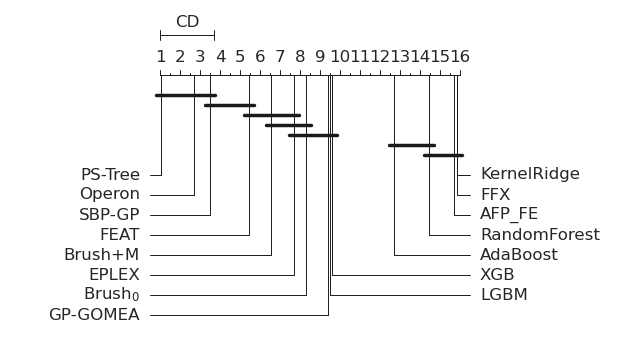

In [9]:
cd_plot(df_results[df_results.dataset.str.contains("_fri_")], figdir+'/'+"cd_fri_results.pdf")

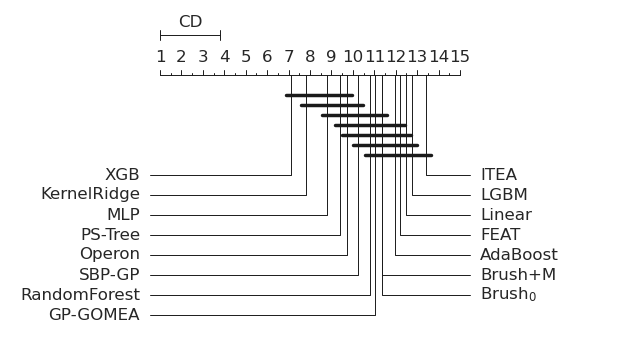

In [10]:
cd_plot(df_results[~df_results.dataset.str.contains("_fri_")], figdir+'/'+"cd_nonfri_results.pdf")